In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

## Neural Network for Classification

In [2]:
# data = pd.read_excel('ML1_dataset.xlsx',sheet_name='ML3 - Banana')
mango = pd.read_excel('ML1_dataset.xlsx',sheet_name='Class 1 - Mango')
orange = pd.read_excel('ML1_dataset.xlsx',sheet_name='Class 2 - Orange')
banana = pd.read_excel('ML1_dataset.xlsx',sheet_name='Class 3 - Banana')

In [3]:
def hue(r,g,b):
    R = r/255
    G = g/255
    B = b/255
    
    max_val = max(R,G,B)
    min_val = min(R,G,B)
    
    if max_val == R:
        hue = (G - B) / (max_val - min_val)
    elif max_val == G:
        hue = 2.0 + (B - R) / (max_val - min_val)
    elif max_val == B:
        hue = 4.0 + (R - G) / (max_val - min_val)   
    else:
        print("Hmmm, something wrong.")
    
    if hue > 0:
        return hue*60
    else:
        return hue + 360

In [4]:
#create hue column
mango['Hue'] = mango.apply(lambda x: hue(x['R'],x['G'],x['B']),axis=1)
orange['Hue'] = orange.apply(lambda x: hue(x['R'],x['G'],x['B']),axis=1)
banana['Hue'] = banana.apply(lambda x: hue(x['R'],x['G'],x['B']),axis=1)

#create label for plotting
mango['Class'] = 'mango'
orange['Class'] = 'orange'
banana['Class'] = 'banana'

orange.head()

,Image,R,G,B,StDev,Median,Skew,AR,Round,Hue,Class
0,1,236.764,200.613,153.233,33.247,138,0.660,1.025,0.976,34.032874,orange
1,2,245.911,266.276,179.424,37.526,156,0.758,1.010,0.990,74.068761,orange
2,3,116.534,109.282,18.273,28.342,115,0.587,1.681,0.595,55.571793,orange
3,4,220.972,215.616,191.501,32.131,147,0.943,1.130,0.885,49.095721,orange
4,5,249.121,206.316,122.162,20.441,151,1.635,1.037,0.965,39.770635,orange


### Activation Functions
We define some of the activation functions we're going to use, along with their derivative functions.

In [5]:
def sigmoid(z,beta):
    sigmoid = (1 / (1 + np.exp(-beta*z)))
    return sigmoid

def dsigmoid(z,beta):
    dsigmoid = sigmoid(z,beta) * (1 - sigmoid(z,beta))
    return dsigmoid

def relu(z):
    z[np.where(z<0)] = 0
    return z

def drelu(z):
    z[np.where(z<0)] = 0
    z[np.where(z>0)] = 1
    return z

def tanh(z):
    return np.tanh(z)

def dtanh(z):
    return (1 + (tanh(z))**2)

def linear(z):
    return z

def dlinear(z):
    return 1

### Initialization and Linear --> Activation 
We provide functions to initialize our weights and another function to complete the step of linear computation and the application of the activation function

In [6]:
def initialize_params(num_hidden,num_input):
    #initialize weight
    w = np.random.randn(num_hidden,num_input)
    return w

def linear_activation(X,w,activation,beta): 
    #calculate for the linear relation
    z = np.dot(X,w.T)

    #apply activation function
    if activation=='sigmoid':
        a = sigmoid(z,beta)
    elif activation=='relu':
        a = relu(z)
    elif activation=='linear':
        a = linear(z)
    elif activation=='tanh':
        a = tanh(z)
    else:
        print('Only sigmoid,relu,linear or tanh for activation.')
        
    return z,a

def gradient_backward(z,activation,beta):
    
    if activation=='relu':
        return drelu(z)
    
    elif activation=='sigmoid':
        return dsigmoid(z,beta)
    
    elif activation=='linear':
        return dlinear(z)
    
    elif activation=='tanh':
        return dtanh(z)
    
    else:
        print('Only sigmoid,relu,linear or tanh for activation.')

### Split Dataset into Train and Test sets

In [7]:
def feature_class(class1,class2,num_train):
    class1['Label'] = 1
    class2['Label'] = 0
    
    feature_input = pd.concat([class1,class2],axis=0,ignore_index=True)
    skew_min, skew_max = feature_input['Skew'].min(), feature_input['Skew'].max()
    feature_input['Skew'] = (feature_input['Skew']-skew_min) / (skew_max-skew_min)
    feature_input['StDev'] = feature_input['StDev']/feature_input['StDev'].max()
    
    #create training set
    train_set_pd = feature_input.sample(num_train)
    train_expected = np.array(train_set_pd['Label']).reshape(-1,1)
    
    train_set = np.ones((num_train,4))
    train_set[:,1:] = train_set_pd[['Skew','StDev','Round']].to_numpy(dtype=float)
    
    #create test set
    test_set_pd = feature_input.drop(train_set_pd.index,axis=0)
    test_expected = np.array(test_set_pd['Label']).reshape(-1,1)
    
    test_set = np.ones((len(test_set_pd),4))
    test_set[:,1:] = test_set_pd[['Skew','StDev','Round']].to_numpy(dtype=float)
    
    return train_set, train_expected, test_set, test_expected

In [8]:
train_set_mo,train_expected_mo,test_set_mo,test_expected_mo = feature_class(mango,orange,30)
train_set_mb,train_expected_mb,test_set_mb,test_expected_mb = feature_class(mango,banana,30)
train_set_bo,train_expected_bo,test_set_bo,test_expected_bo = feature_class(banana,orange,30)

print('Train dataset:',train_set_mo.shape)
print('Test dataset:',test_set_mo.shape)

Train dataset: (30, 4)
Test dataset: (12, 4)


### 2-Layer Neural Network

In [9]:
def neural_network(features,expected,activation_1,activation_2,beta,n_f,n_h,n_o,num_iterations,lc_rate_1,lc_rate_2):
    
    #initialize weights
    w1 = initialize_params(n_h,n_f) 
    w2 = initialize_params(n_o,n_h) 
    
    cost = []
    for i in range(num_iterations):
        
        z1, a1 = linear_activation(features,w1,activation_1,beta)
        z2, a2 = linear_activation(a1,w2,activation_2,beta)
        
        cost_func = 0.5*np.sum((a2-expected)**2)
        cost.append(cost_func)

        #compute error of each output
        error_out = np.multiply(gradient_backward(z2,activation_2,beta),(a2-expected))
        
        #compute errors for hidden units
        error_hid = np.multiply(gradient_backward(z1,activation_1,beta),np.dot(error_out,w2))
        
        #error derivatives
        error_div_2 = np.dot(error_out.T,a1)           
        error_div_1 = np.dot(error_hid.T,features)
        
        #update weights using gradient descent
        w1 -= lc_rate_1*error_div_1
        w2 -= lc_rate_2*error_div_2

    params = {'w1':w1,'w2':w2,'cost':cost}
        
    return params

In [10]:
act1, act2, beta, hidden, iterations, lc1, lc2 = 'linear', 'sigmoid', 0.5, 10, 10000, 0.01, 0.01
params_mo = neural_network(train_set_mo,train_expected_mo,act1,act2,beta,train_set_mo.shape[1],hidden,1,iterations,lc1,lc2)
params_mb = neural_network(train_set_mb,train_expected_mb,act1,act2,beta,train_set_mb.shape[1],hidden,1,iterations,lc1,lc2)
params_bo = neural_network(train_set_bo,train_expected_bo,act1,act2,beta,train_set_bo.shape[1],hidden,1,iterations,lc1,lc2)

Encountering overflow error. I guess, the sum of squares error (SSE) is not an overall efficient cost function since the values keeps getting bigger with no minimization. There also seemed to be more than one minima after n iterations.

### Plot cost functions of the NN model

In [11]:
def cost_plot(params,c1,c2,savename):

    x_range = np.arange(0,len(params['cost']))

    plt.title('2-Layer Neural Network Cost Function for {}-{}'.format(c1,c2))
    plt.xlabel('Number of iterations')
    plt.ylabel('Cost Function')

    plt.plot(x_range,params['cost'])
    plt.savefig(savename,bbox_inches='tight',dpi=300)
    plt.show()

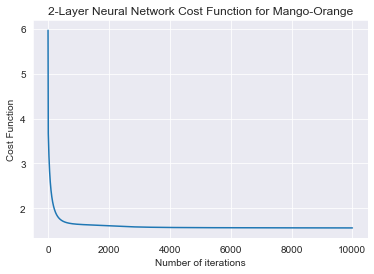

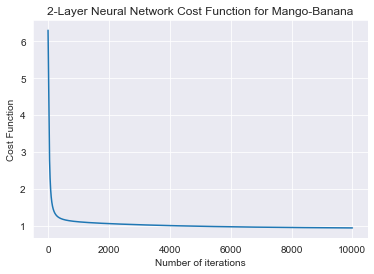

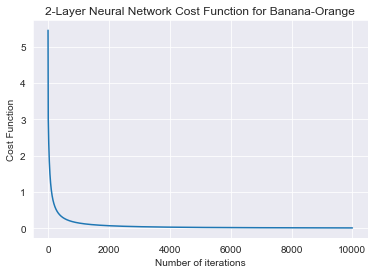

In [12]:
cost_plot(params_mo,'Mango','Orange','nn_costfunction_mo.png')
cost_plot(params_mb,'Mango','Banana','nn_costfunction_mb.png')
cost_plot(params_bo,'Banana','Orange','nn_costfunction_bo.png')

### Train accuracy of the model
I was told that accuracy is not needed if the output is NOT BINARY. Also, we shouldn't generalize the prediction by imposing a threshold of 0.5 for a sigmoid!

In [18]:
def accuracy(params,train_set,train_expected,activation_1,activation_2,beta,threshold):
    
    w1, w2 = params['w1'], params['w2']

    z1_train, a1_train = linear_activation(train_set,w1,activation_1,beta)
    z2_train, a2_train = linear_activation(a1_train,w2,activation_2,beta)

    train_output = pd.DataFrame([a2_train.flatten(),train_expected.flatten()],index=['predicted','expected']).T
    true_pos = train_output[(train_output.predicted > threshold) & (train_output.expected == 1)]
    true_neg = train_output[(train_output.predicted < threshold) & (train_output.expected == 0)]
    correct = len(true_pos) + len(true_neg)
    accuracy = (correct/len(train_output))*100

    return accuracy

In [26]:
act1, act2, beta = 'linear', 'sigmoid', 0.2

print("Mango-Orange Model Training Accuracy")
for i in range(1,10):
    print("For threshold of {:1f}, accuracy is {}"\
          .format(0.1*i,accuracy(params_mo,train_set_mo,train_expected_mo,act1,act2,beta,0.1*i)))

print("Mango-Banana Model Training Accuracy")
for i in range(1,10):
    print("For threshold of {:1f}, accuracy is {}"\
          .format(0.1*i,accuracy(params_mb,train_set_mb,train_expected_mb,act1,act2,beta,0.1*i)))

print("Banana-Orange Model Training Accuracy")
for i in range(1,10):
    print("For threshold of {:1f}, accuracy is {}"\
          .format(0.1*i,accuracy(params_bo,train_set_bo,train_expected_bo,act1,act2,beta,0.1*i)))

Mango-Orange Model Training Accuracy
For threshold of 0.100000, accuracy is 53.333333333333336
For threshold of 0.200000, accuracy is 66.66666666666666
For threshold of 0.300000, accuracy is 73.33333333333333
For threshold of 0.400000, accuracy is 83.33333333333334
For threshold of 0.500000, accuracy is 83.33333333333334
For threshold of 0.600000, accuracy is 83.33333333333334
For threshold of 0.700000, accuracy is 80.0
For threshold of 0.800000, accuracy is 76.66666666666667
For threshold of 0.900000, accuracy is 60.0
Mango-Banana Model Training Accuracy
For threshold of 0.100000, accuracy is 73.33333333333333
For threshold of 0.200000, accuracy is 76.66666666666667
For threshold of 0.300000, accuracy is 86.66666666666667
For threshold of 0.400000, accuracy is 93.33333333333333
For threshold of 0.500000, accuracy is 90.0
For threshold of 0.600000, accuracy is 93.33333333333333
For threshold of 0.700000, accuracy is 86.66666666666667
For threshold of 0.800000, accuracy is 80.0
For thre

### Test accuracy of the model
I was told that accuracy is not needed if the output is NOT BINARY. Also, we shouldn't generalize the prediction by imposing a threshold of 0.5 for a sigmoid!

In [27]:
print("Mango-Orange Model Test Accuracy")
for i in range(1,10):
    print("For threshold of {:1f}, accuracy is {}"\
          .format(0.1*i,accuracy(params_mo,test_set_mo,test_expected_mo,act1,act2,beta,0.1*i)))
    
print("Mango-Banana Model Test Accuracy")
for i in range(1,10):
    print("For threshold of {:1f}, accuracy is {}"\
          .format(0.1*i,accuracy(params_mb,test_set_mb,test_expected_mb,act1,act2,beta,0.1*i)))

print("Banana-Orange Model Test Accuracy")
for i in range(1,10):
    print("For threshold of {:1f}, accuracy is {}"\
          .format(0.1*i,accuracy(params_bo,test_set_bo,test_expected_bo,act1,act2,beta,0.1*i)))

Mango-Orange Model Test Accuracy
For threshold of 0.100000, accuracy is 58.333333333333336
For threshold of 0.200000, accuracy is 66.66666666666666
For threshold of 0.300000, accuracy is 83.33333333333334
For threshold of 0.400000, accuracy is 91.66666666666666
For threshold of 0.500000, accuracy is 83.33333333333334
For threshold of 0.600000, accuracy is 83.33333333333334
For threshold of 0.700000, accuracy is 91.66666666666666
For threshold of 0.800000, accuracy is 83.33333333333334
For threshold of 0.900000, accuracy is 83.33333333333334
Mango-Banana Model Test Accuracy
For threshold of 0.100000, accuracy is 66.66666666666666
For threshold of 0.200000, accuracy is 83.33333333333334
For threshold of 0.300000, accuracy is 91.66666666666666
For threshold of 0.400000, accuracy is 91.66666666666666
For threshold of 0.500000, accuracy is 75.0
For threshold of 0.600000, accuracy is 75.0
For threshold of 0.700000, accuracy is 83.33333333333334
For threshold of 0.800000, accuracy is 75.0
For

## Neural Network for Curve Fitting

In [348]:
def function(f,N,x_min,x_max):
    
    x = (np.linspace(x_min,x_max,N)).reshape(1,-1)          
    X = np.ones((N,2))
    X[:,1] = x
    
    if f=='sine':
        y = (np.sin(2*np.pi*x)+1).reshape(-1,1)
        Y = y/max(y)
    elif f=='parabola':
        Y = (x**2).reshape(-1,1)
    else:
        None
    
    return X, Y

### Using Neural Network Model to Predict for Sine Function

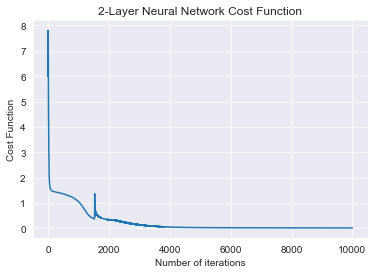

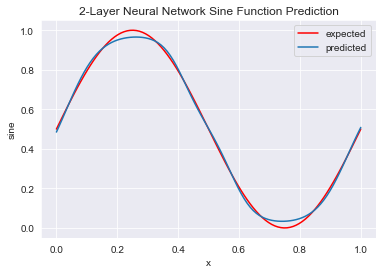

In [402]:
#learn weights
beta_sine = 0.5
X_sine, Y_sine = function('sine',100,0,1)
sine = neural_network(X_sine,Y_sine,'sigmoid','sigmoid',beta_sine,X_sine.shape[1],10,1,10000,0.3,0.3)

w1_sine = sine['w1'] 
w2_sine = sine['w2']

z1_sine, a1_sine = linear_activation(X_sine,w1_sine,'sigmoid',beta_sine)
z2_sine, a2_sine = linear_activation(a1_sine,w2_sine,'sigmoid',beta_sine)

#plot cost function
plt.title('2-Layer Neural Network Cost Function')
plt.xlabel('Number of iterations')
plt.ylabel('Cost Function')

plt.plot(np.arange(0,len(sine['cost'])),sine['cost'])
plt.savefig('nn_sinecostfunction.png',bbox_inches='tight',dpi=300)
plt.show()

#plot predicted function
plt.plot(X_sine[:,1].flatten(),Y_sine.flatten(),color='red',label='expected')
plt.plot(X_sine[:,1].flatten(),a2_sine.flatten(),label='predicted')

plt.xlabel('x')
plt.ylabel('sine')
plt.title('2-Layer Neural Network Sine Function Prediction')
plt.legend(loc='upper right')

plt.savefig('sine_predict.png',bbox_inches='tight',dpi=300)
plt.show()

### Using Neural Network Model to Predict for Parabola Function

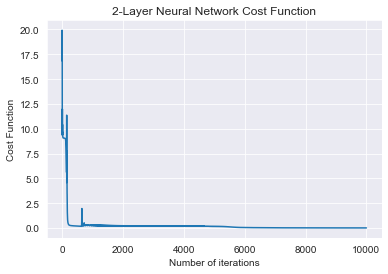

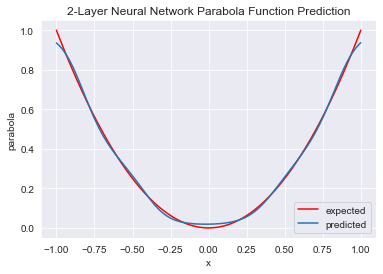

In [388]:
#learn weights
beta_par = 0.2
X_para, Y_para = function('parabola',200,-1,1)
para = neural_network(X_para,Y_para,'sigmoid','sigmoid',beta_par,X_para.shape[1],20,1,10000,0.4,0.4)

w1_para = para['w1'] 
w2_para = para['w2']

z1_para, a1_para = linear_activation(X_para,w1_para,'sigmoid',beta_par)
z2_para, a2_para = linear_activation(a1_para,w2_para,'sigmoid',beta_par)

#plot cost function
plt.title('2-Layer Neural Network Cost Function')
plt.xlabel('Number of iterations')
plt.ylabel('Cost Function')

plt.plot(np.arange(0,len(para['cost'])),para['cost'])
plt.savefig('nn_paracostfunction.png',bbox_inches='tight',dpi=300)
plt.show()

#plot predicted function
plt.plot(X_para[:,1].flatten(),Y_para.flatten(),color='red',label='expected')
plt.plot(X_para[:,1].flatten(),a2_para.flatten(),label='predicted')

plt.xlabel('x')
plt.ylabel('parabola')
plt.title('2-Layer Neural Network Parabola Function Prediction')
plt.legend(loc='lower right')

plt.savefig('para_predict.png',bbox_inches='tight',dpi=300)
plt.show()